In [60]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from xgboost import XGBClassifier
from sklearn.preprocessing import MinMaxScaler

In [61]:
data = pd.read_csv('C:/Users/arsha/Desktop/APM/final_dataset.csv')
data=data.drop(columns=['city','no2','so2','co','o3','aqi'])
X = data[[
    'pm25',
    'pm10',
    # 'NO2',
    # 'SO2',
    # 'CO',
    # 'O3',
    'temp',
    'humidity'
]]

y = data['aqi_category']
y.head()


0    Very Poor
1    Very Poor
2     Moderate
3     Moderate
4    Very Poor
Name: aqi_category, dtype: object

In [62]:
le = LabelEncoder()
y_encoded = le.fit_transform(y)
y_encoded

array([5, 5, 1, ..., 4, 2, 4], shape=(3287,))

In [63]:
data['date'] = pd.to_datetime(data['date'])

# train = data[data['date'].dt.year < 2020]
# test = data[data['date'].dt.year == 2020]

# X_train = train[X.columns]
# y_train = le.transform(train['aqi_category'])

# X_test = test[X.columns]
# y_test = le.transform(test['aqi_category'])
from sklearn.model_selection import train_test_split



X_train, X_test, y_train, y_test = train_test_split(
    X,
    y_encoded,
    test_size=0.2,
    stratify=y_encoded,      # ⭐ VERY IMPORTANT
    random_state=42
)


In [64]:
data['aqi_category'].value_counts()


aqi_category
Moderate        1229
Poor             721
Satisfactory     612
Very Poor        517
Severe           137
Good              71
Name: count, dtype: int64

In [65]:
# scaler = MinMaxScaler()

# train_scaled = scaler.fit_transform(train[['NO2','SO2','CO','O3']])
# test_scaled  = scaler.transform(test[['NO2','SO2','CO','O3']])

# train['Gas_Index'] = (
#     0.59 * train_scaled[:,2] +   # CO
#     0.32 * train_scaled[:,3] +   # O3
#     0.06 * train_scaled[:,0] +   # NO2
#     0.03 * train_scaled[:,1]     # SO2
# )

# test['Gas_Index'] = (
#     0.59 * test_scaled[:,2] +
#     0.32 * test_scaled[:,3] +
#     0.06 * test_scaled[:,0] +
#     0.03 * test_scaled[:,1]
# )


# features = ['PM2.5','Gas_Index','temperature','humidity']

# X_train = train[features]
# X_test  = test[features]
X_train.head()

,pm25,pm10,temp,humidity
1951,181.055960,231.161454,30.1,77
1481,102.801839,126.370190,23.5,74
152,96.977725,148.804876,30.4,73
26,57.080118,122.262611,24.1,69
273,70.492003,120.611863,27.6,82


In [66]:
# import xgboost as xgb

model = XGBClassifier(
    booster='dart',
    n_estimators=100,
    max_depth=3,
    learning_rate=0.05,
    rate_drop=0.1,           # Dropout rate for trees
    colsample_bytree=0.5,
    random_state=42
)

model.fit(X_train, y_train)


# model = XGBClassifier(
#     n_estimators=200,
#     max_depth=4,
#     learning_rate=0.05,
#     random_state=42,
#     subsample=0.8,        # row sampling
#     colsample_bytree=0.8, # feature sampling
#     reg_lambda=1,
#     reg_alpha=0.5
# )

# model.fit(X_train, y_train)


,objective,'multi:softprob'
,use_label_encoder,False
,base_score,0.5
,booster,'dart'
,callbacks,None
,colsample_bylevel,1
,colsample_bynode,1
,colsample_bytree,0.5
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,None


In [67]:
y_pred = model.predict(X_test)
from sklearn.metrics import accuracy_score

accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)


Accuracy: 0.9741641337386018


In [68]:
from sklearn.metrics import classification_report

print(classification_report(y_test, y_pred, target_names=le.classes_))
# print(le.classes_)




              precision    recall  f1-score   support

        Good       1.00      0.93      0.96        14
    Moderate       0.96      1.00      0.98       246
        Poor       1.00      1.00      1.00       144
Satisfactory       0.94      1.00      0.97       123
      Severe       1.00      0.41      0.58        27
   Very Poor       1.00      1.00      1.00       104

    accuracy                           0.97       658
   macro avg       0.98      0.89      0.92       658
weighted avg       0.98      0.97      0.97       658



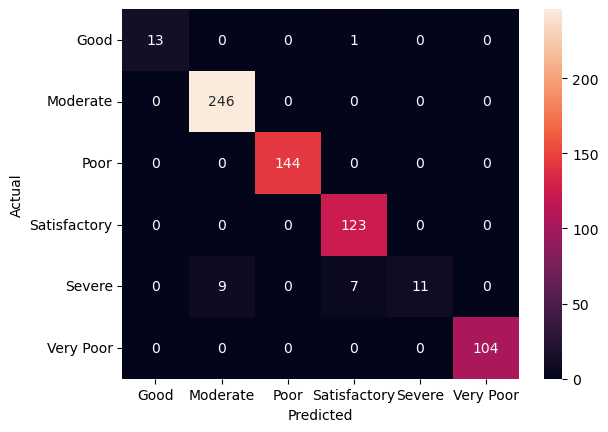

In [69]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

cm = confusion_matrix(y_test, y_pred)

fig, ax = plt.subplots()
sns.heatmap(cm, annot=True, fmt='d',
            xticklabels=le.classes_,
            yticklabels=le.classes_, ax=ax)

# # Highlight diagonal cells
# for i in range(len(cm)):
#     ax.add_patch(Rectangle((i, i), 1, 1, fill=False, edgecolor='red', linewidth=3))

plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

In [70]:
import pandas as pd

importance = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': model.feature_importances_
}).sort_values(by='Importance', ascending=False)
print(importance)


    Feature  Importance
0      pm25    0.685265
1      pm10    0.306688
2      temp    0.004320
3  humidity    0.003727


In [71]:
print("Train accuracy:", model.score(X_train, y_train))
print("Test accuracy:", model.score(X_test, y_test))

Train accuracy: 0.9767972613160898
Test accuracy: 0.9741641337386018


In [75]:

temp= 28.00
humidity= 74.00
# MQ135 Analog: 627
pm25= 59
pm10= 27
y_pred = model.predict(pd.DataFrame([[pm25, pm10, temp, humidity]], columns=['pm25', 'pm10', 'temp', 'humidity']))
print("Predicted AQI Bucket:", le.inverse_transform(y_pred))

Predicted AQI Bucket: ['Good']


In [ ]:
model.save_model('xgb_model.json')


ValueError: training data did not have the following fields: pm25, pm10, temp, humidity